# Starbucks Capstone Challenge

- <a id='TOC'>Table of Contents</a>
    - <a href='#Intro'>Introduction </a>
        - <a href='#Dataset'>Datasets definition </a>
        - <a href='#authornote'>Author Notes</a> 
    - <a href='#sec_0_0'>Section 0: Import Librarys and Data </a>
    - <a href='#sec_1_0'>Section 1: Clean and Organizae Data </a>
        - <a href='#sec_1_1'>Section 1.1: Match Transcript </a>
    - <a href='#sec_2_0'>Section 2: Explore Data </a>
        - <a href='#sec_2_1'>Section 2.1: Genreal Exploration </a>
        - <a href='#sec_2_2'>Section 2.2: Demographic Histographical Analysis </a>
        - <a href='#sec_2_3'>Section 2.3: Exploration of Response Variables </a>
    - <a href='#sec_3_0'>Section 3: Model Data </a>

<a id='Intro'></a>
## Introduction  
<a href='#TOC'>Jump to top </a>

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

<a id='Dataset'></a>

### Data Sets
<a href='#TOC'>Jump to top </a>

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


<a id='authornote'></a>
### Author Notes

Expanded notes on thought process are contained in <a href='Notes.ipynb'>Notes.ipynb Jupyter notebook</a> which is stored in the same directory

<a id='sec_0_0'></a>
## 0. Import Librarys and Data
<a href='#TOC'>Jump to top </a>

In [1]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
tqdm.pandas()
import json

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer 
from sklearn.cluster import KMeans
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

<a href='#pick_load'>Jump to the latest pickle load checkpoint</a>

<a id='sec_1_0'></a>
## 1. Clean and Organize Data

<a href='#TOC'>Jump to top </a>

In [3]:
## Are all the missing gender and income on matching rows?
(17000-14825)==profile[(profile.gender.isna())&(profile.income.isna())].shape[0]

True

In [4]:
def organize_raw_data(portfolio=portfolio,profile=profile,transcript=transcript):
    ''' This function organizes the raw data via setting datatype, setting indexes, and onehotencoding
    input: Startbuck challenge raw dataframes: portfolio,profile, and transcrips
    
    output: (7 dataframes, 3 revised originals and 4 which are filtered versions of transcript)
    portfolio_new: portfolio (one hot encoded channels, some column renames)
    profile_new: cleaned profile (member start date to datetime, one hot encoded gender)
    transcript_new: cleaned transcript 
        (value dict-> one hot encoded event type, 
        amount(spend), reward(completion), offer_id(offers,view/complte))
    t_offer: transcript_new filtered:offers only
    t_viewed: transcript_new filtered:viewed only
    t_trans: transcript_new filtered:transactions only
    t_compl: transcript_new filtered:complteted offers only
    
    '''
    
    
    ############### Portfolio
    portfolio.rename(columns={'id':'offer_id'},inplace=True) # match other table
    
    # one hot encode channels
    mlb = MultiLabelBinarizer() 
    portfolio = portfolio.join(pd.DataFrame(mlb.fit_transform(portfolio.pop('channels')),
                          columns=mlb.classes_,
                          index=portfolio.index))
    portfolio = portfolio.merge(pd.get_dummies(portfolio['offer_type'],prefix='offer',prefix_sep='_'),left_index=True,right_index=True)
    #portfolio.drop(columns='offer_type',inplace=True)
    # Since offer_id is unique, we can use that as an index
    portfolio.set_index('offer_id')
    
    ############### Profile
    #Split/Drop N/A  - approx 13% of profile data was missing gender and income, the rows missing gender also are missing income.
    #  Will look to see if there are any differences later on
    profile_na = profile[profile.gender.isna()]
    #profile = profile.dropna(axis = 0)  - Will be doing this later so the profile N/A lines will be processed
    
    #Convert to datetime
    profile.loc[:,'became_member_on']=pd.to_datetime(profile['became_member_on'],format='%Y%m%d')
    
    #one hot encode gender
    profile = profile.merge(pd.get_dummies(profile['gender'],prefix='gender',prefix_sep='_'),left_index=True,right_index=True)
    
    # Since id is unique, we can use that as an index
    profile.set_index('id',inplace=True)
    
    
    ################# Transcript
    
    # expand dict in 'value' to its own columns per dict key
    transcript = transcript.merge(transcript.value.apply(pd.Series),left_index=True,right_index=True)
    
    # cleaning up 'offer_id' and 'offer id', so as there is a single column
    transcript.loc[transcript['offer_id'].isna(),'offer_id'] = transcript[transcript['offer_id'].isna()]['offer id']
    
    #one hot encode event (transaction type)
    transcript = transcript.merge(pd.get_dummies(transcript['event'],prefix='event',prefix_sep='_'),left_index=True, right_index=True)
    transcript.drop(columns = ['offer id','value'],inplace=True)
    
    transcript = transcript[transcript['person'].isin(profile.index)].reset_index()
    
    #break apart into sub-df based on transaction tyle
    t_offer = transcript[transcript['event']=='offer received']
    t_viewed = transcript[transcript['event']=='offer viewed']
    t_trans = transcript[transcript['event']=='transaction']
    t_compl = transcript[transcript['event']=='offer completed']
    
    return portfolio,profile,profile_na,transcript,t_offer,t_viewed,t_trans,t_compl

In [5]:
portfolio_new,profile_new,profile_na,transcript_new,t_offer,t_viewed,t_trans,t_compl = organize_raw_data()

In [6]:
print('portfolio:', portfolio.shape)
print('portfolio_new',portfolio_new.shape)
print('profile',profile.shape)
print('profile_new', profile_new.shape)
print('transcript',transcript.shape)
print('transcript_new',transcript_new.shape)
print('t_offer',t_offer.shape)
print('t_viewed',t_viewed.shape)
print('t_compl',t_compl.shape)
print('t_trans',t_trans.shape)


portfolio: (10, 5)
portfolio_new (10, 12)
profile (17000, 5)
profile_new (17000, 7)
transcript (306534, 4)
transcript_new (306534, 11)
t_offer (76277, 11)
t_viewed (57725, 11)
t_compl (33579, 11)
t_trans (138953, 11)


<a id='sec_1_1'></a>
### 1.1 Matching Events
<a href='#TOC'>Jump to top </a>

The purpose of this section is to match pertinent events to thier respective offer.  So you have one row representing a series of events.
- All counted views are performed within the time window: time (of offer) + duration of offer
- All counted transactions are performed within the time window and after they view the offer.
- All rewards occur within time wintow

In [7]:
###Lookup the duration of each offer and convert to hours to match offer time data.
###and create a time end

t_matched = pd.merge(t_offer,portfolio[['offer_id','duration']],on=['offer_id'],how='left')
t_matched['duration'] =t_matched['duration'].progress_apply(lambda x: x*24)
t_matched['time_end'] = t_matched['time'] + t_matched['duration']


###
### Merge view transcripts!
###

def id_viewed(row):
    ''' matches up offers and views by same person and offer within time limit.   
    Marks offer/person/time as viewed and notes the time of the view.
    
    input: df row per pd.apply()
    output: updated df row 
    '''
    for idx,trn in t_viewed[(t_viewed.person == row.person)&(t_viewed.offer_id == row.offer_id)].sort_values(by='time').iterrows():
        if (trn.time >= row.time) & (trn.time < row.time_end ):
            row['event_offer viewed'] = 1
            row['time_viewed'] = trn['time']
            return row
    return row

t_matched = t_matched.progress_apply(id_viewed,axis=1)

###
### merge transaction transcript!
###

t_matched['trans_time'] = np.nan
#t_matched['trans_index'] = np.nan  # Vestigal
t_matched['trans_spend'] = np.nan
t_matched['reward'] = np.nan

def scrub_trans(row):
    '''
    Matches transactions to offer based on the following conditions
    - person matches
    - transaction was made after offer was made
    - transaction was viewed
    - transaction was made after the offer was viewed
    - transaction was made before offer expired.
    '''
    #print(row['person'])
    for idx,trn in t_trans[t_trans.person == row.person].sort_values(by='time').iterrows():
        if (trn.time >= row.time) & (row['event_offer viewed']==1) &(trn.time < row.time_end ) & (trn.time >= row.time_viewed):
            row['event_transaction'] = 1
            row['trans_time'] = trn['time']
            row['trans_spend'] = trn['amount']
            return row
    return row
 

t_matched = t_matched.progress_apply(scrub_trans,axis=1)



###
### Merge completed transactions
###

t_matched['reward'] = np.nan

def scrub_compl(row):
    '''   
    Runs through the t_offer dataframe and marks offer as complete under the following contionds
    

    marks the offer complete if
    - person and offer match
    - 
    
    input: df row per pd.apply() function
    '''
    for idx,trn in t_compl[(t_compl.person == row.person)&(t_compl.offer_id == row.offer_id)].sort_values(by='time').iterrows():
        if (trn.time >= row.time) & (trn.time < row.time_end ):
            row['event_offer completed'] = 1
            row['reward'] = trn.reward
            
            return row
    return row
 

t_matched = t_matched.progress_apply(scrub_compl,axis=1)

100%|██████████| 76277/76277 [22:46<00:00, 55.84it/s] 


In [8]:


###
### Save df to pickle
###

t_matched.to_pickle('combined_trans.pkl')

In [9]:
events = pd.read_pickle('combined_trans.pkl')

**Combine profile and portfolio information to each line**

In [10]:
# Merge pertinant fields from profile

profile_new['memb_leng'] = (profile_new.became_member_on.max()-profile_new.became_member_on).dt.days.astype(float)/30.416

prof_merge_col = ['age','income','gender','gender_F',
       'gender_M', 'gender_O', 'memb_leng']

events = events.merge(profile_new[prof_merge_col],how='left',left_on='person',right_on=profile_new.index)

# Merge pertinant fields from portfolio

portfolio_new.columns

port_merge_col = ['difficulty', 'offer_id', 'email', 'mobile',
       'social', 'web', 'offer_bogo', 'offer_discount',
       'offer_informational']

events = events.merge(portfolio_new[port_merge_col],on='offer_id')

**N/A Strategy**

There are five columns with N/A in the data
    - time_viewed
    - trans_time
    - trans_spend
    - income
    - gender
    
    1) time_viewed and trans_time are response variables (y) for those who completed those tasks.  I will remove these from the dataset for any predictive modeling
    2) Income and gender are omitted on appox 13% of records.  Important  to note that the income and gender are all missing from the same lines. Will remove these later when pertinant
    3) trans_spend should be zero, if there was no transaction there was no spend

In [11]:
events.trans_spend = events.trans_spend.fillna(value=0)

events.to_pickle('events_merged.pkl')

<a id='pick_load'> Pickle Load</a>


In [12]:
events_merged = pd.read_pickle('events_merged.pkl')

In [13]:
events_merged.head()

,amount,duration,event,event_offer completed,event_offer received,event_offer viewed,event_transaction,index,offer_id,person,...,gender_O,memb_leng,difficulty,email,mobile,social,web,offer_bogo,offer_discount,offer_informational
0,NaN,168,offer received,1,1,1,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,...,0,14.564703,5,1,1,0,1,1,0,0
1,NaN,168,offer received,0,1,0,0,18,9b98b8c7a33c4b65b9aebfe6a799e6d9,ebe7ef46ea6f4963a7dd49f501b26779,...,0,42.148869,5,1,1,0,1,1,0,0
2,NaN,168,offer received,1,1,1,1,21,9b98b8c7a33c4b65b9aebfe6a799e6d9,f082d80f0aac47a99173ba8ef8fc1909,...,0,24.559442,5,1,1,0,1,1,0,0
3,NaN,168,offer received,1,1,1,1,28,9b98b8c7a33c4b65b9aebfe6a799e6d9,c0d210398dee4a0895b24444a5fcd1d2,...,0,0.624671,5,1,1,0,1,1,0,0
4,NaN,168,offer received,0,1,0,0,30,9b98b8c7a33c4b65b9aebfe6a799e6d9,57dd18ec5ddc46828afb81ec5977bef2,...,0,17.556549,5,1,1,0,1,1,0,0


In [14]:
events_merged.columns

Index(['amount', 'duration', 'event', 'event_offer completed',
       'event_offer received', 'event_offer viewed', 'event_transaction',
       'index', 'offer_id', 'person', 'reward', 'time', 'time_end',
       'time_viewed', 'trans_time', 'trans_spend', 'age', 'income', 'gender',
       'gender_F', 'gender_M', 'gender_O', 'memb_leng', 'difficulty', 'email',
       'mobile', 'social', 'web', 'offer_bogo', 'offer_discount',
       'offer_informational'],
      dtype='object')

<a id='pickleload'></a>

<a id='sec_2_0'></a>
## Section 2.0: Explore Data
<a href='#TOC'>Jump to top</a>

<a id='sec_2_1'></a>
### Section 2.1: General Exploration
<a href='#TOC'>Jump to top</a>

In [15]:
events_merged.columns

Index(['amount', 'duration', 'event', 'event_offer completed',
       'event_offer received', 'event_offer viewed', 'event_transaction',
       'index', 'offer_id', 'person', 'reward', 'time', 'time_end',
       'time_viewed', 'trans_time', 'trans_spend', 'age', 'income', 'gender',
       'gender_F', 'gender_M', 'gender_O', 'memb_leng', 'difficulty', 'email',
       'mobile', 'social', 'web', 'offer_bogo', 'offer_discount',
       'offer_informational'],
      dtype='object')

In [16]:
events_merged.rename(columns={'event_offer completed':'event_offer_completed',
       'event_offer received':'event_offer_received', 'event_offer viewed':'event_offer_viewed'},inplace=True)

In [17]:
print(events_merged[['event_offer_received','event_offer_viewed','event_transaction','event_offer_completed']].sum())

tot_offers = events_merged.event_offer_received.sum()
tot_off_viewed = events_merged.event_offer_viewed.sum()
tot_off_purchased = events_merged.event_transaction.sum()
tot_off_rewarded = events_merged.event_offer_completed.sum()



tot_sum_purch = events_merged.trans_spend.sum()
#tot_sum_reward = events_merged.reward.sum()


print('Percentage viewed : {0:.2f}%'.format(100* tot_off_viewed/tot_offers))
print('Percentage offers purchased : {0:.2f}%'.format(100*tot_off_purchased/tot_offers))
print('Percentage offers viewed puchased : {0:.2f}%'.format(100*tot_off_purchased/tot_off_viewed))
print('Percentage of offers that were rewarded  : {0:.2f}%'.format(100*tot_off_rewarded/tot_off_purchased))
print('Percentage of purchases that were rewarded  : {0:.2f}%'.format(100*tot_off_rewarded/tot_off_purchased))

event_offer_received     76277
event_offer_viewed       56651
event_transaction        43067
event_offer_completed    33195
dtype: int64
Percentage viewed : 74.27%
Percentage offers purchased : 56.46%
Percentage offers viewed puchased : 76.02%
Percentage of offers that were rewarded  : 77.08%
Percentage of purchases that were rewarded  : 77.08%


In [18]:
events_merged.columns

Index(['amount', 'duration', 'event', 'event_offer_completed',
       'event_offer_received', 'event_offer_viewed', 'event_transaction',
       'index', 'offer_id', 'person', 'reward', 'time', 'time_end',
       'time_viewed', 'trans_time', 'trans_spend', 'age', 'income', 'gender',
       'gender_F', 'gender_M', 'gender_O', 'memb_leng', 'difficulty', 'email',
       'mobile', 'social', 'web', 'offer_bogo', 'offer_discount',
       'offer_informational'],
      dtype='object')

<a id='sec_2_2'></a>
### Section 2.2: Demographic Histographical Analysis
<a href='#TOC'>Jump to top</a>

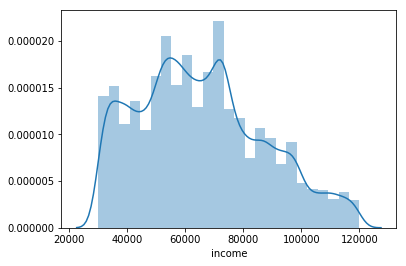

In [19]:

sns.distplot(events_merged.income.dropna(),bins=25)

In [20]:
#it appears that there are some groupings in this distribution

In [21]:
events_merged[['gender_M','gender_F','gender_O']].sum()

gender_M    38129
gender_F    27456
gender_O      916
dtype: int64

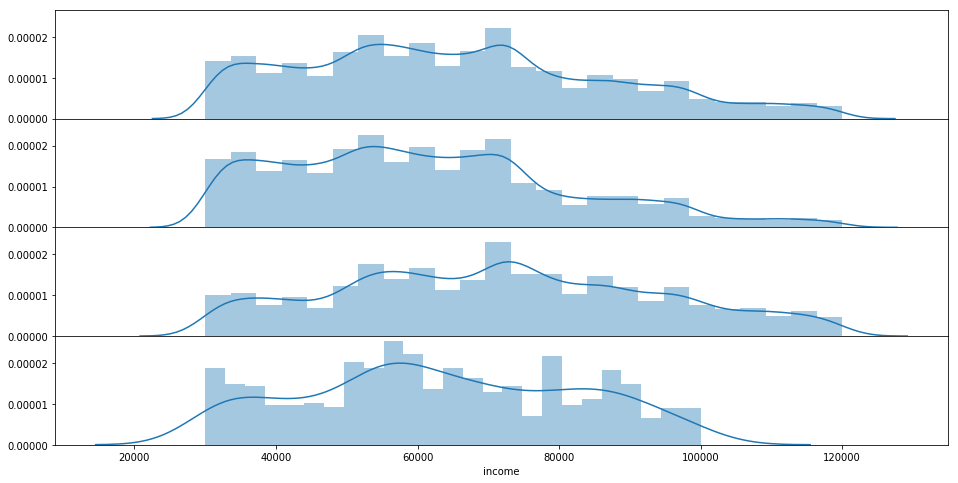

In [22]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, sharex=True,sharey=True, figsize=(16,8))
fig.subplots_adjust(hspace = 0)
sns.distplot(events_merged.income.dropna(),bins=25,ax=ax0)
sns.distplot(events_merged[events_merged.gender_M == 1].income.dropna(),bins=25,ax=ax1)
sns.distplot(events_merged[events_merged.gender_F == 1].income.dropna(),bins=25,ax=ax2)
sns.distplot(events_merged[events_merged.gender_O == 1].income.dropna(),bins=25,ax=ax3)

There appears to be groupings within the income, that are not related to gender.  It apppears to be 3-5 subgroups.  There are possibly something implit here.

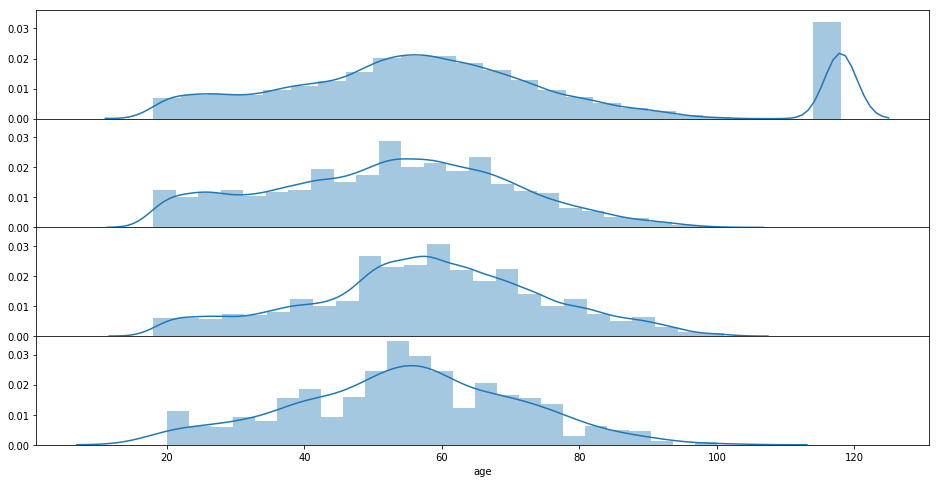

In [23]:


fig2, (ax2_0, ax2_1, ax2_2, ax2_3) = plt.subplots(nrows=4, sharey= True, sharex=True,figsize=(16,8))
fig2.subplots_adjust(hspace = 0)
sns.distplot(events_merged.age.dropna(),bins=25,ax=ax2_0)
sns.distplot(events_merged[events_merged.gender_M == 1].age.dropna(),bins=25,ax=ax2_1)
sns.distplot(events_merged[events_merged.gender_F == 1].age.dropna(),bins=25,ax=ax2_2)
sns.distplot(events_merged[events_merged.gender_O == 1].age.dropna(),bins=25,ax=ax2_3)

It appears that the people who are N/A are all '118'y/o

In [24]:
profile[profile.age>100].shape[0]/profile.shape[0]

0.12823529411764706

There does appear to be two groupings here within the data

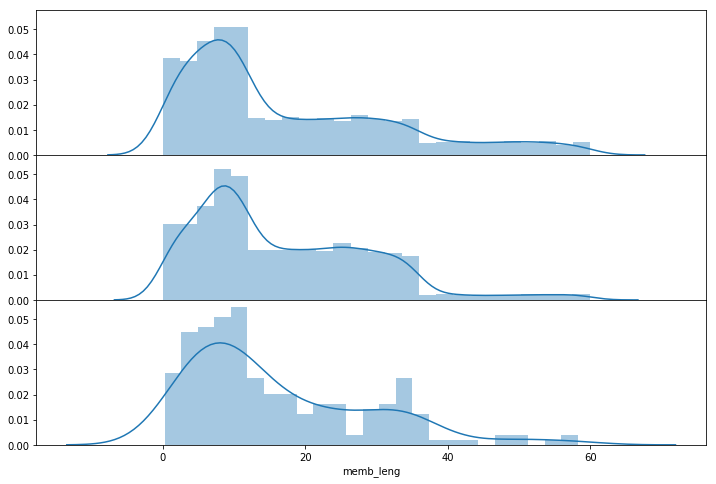

In [25]:
fig3, (ax3_1, ax3_2, ax3_3) = plt.subplots(nrows=3, sharex=True,sharey=True, figsize=(12,8))
fig3.subplots_adjust(hspace = 0)
sns.distplot(profile_new[profile_new.gender_M == 1].memb_leng,bins=25,ax=ax3_1)
sns.distplot(profile_new[profile_new.gender_F == 1].memb_leng,bins=25,ax=ax3_2)
sns.distplot(profile_new[profile_new.gender_O == 1].memb_leng,bins=25,ax=ax3_3)

There appears to be 3 distinct groups of members based on membership length
* members joining between ~38-58months
* members joining between ~12-38 months
* members joining in last 12 months 



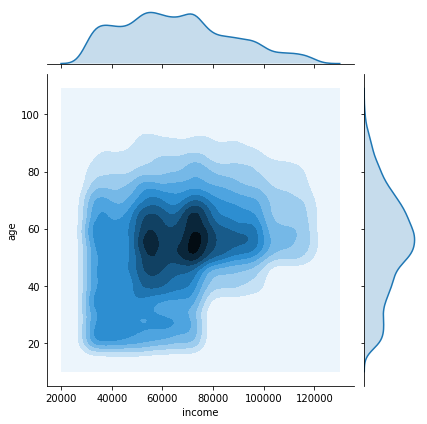

In [26]:
sns.jointplot(x='income',y='age',data=profile_new.dropna(subset=['income','age']),kind="kde")

Interesting here, the income distributions of younger folks is is limited to the lower end of the range and expandands as age increases.  Also age skews lower.

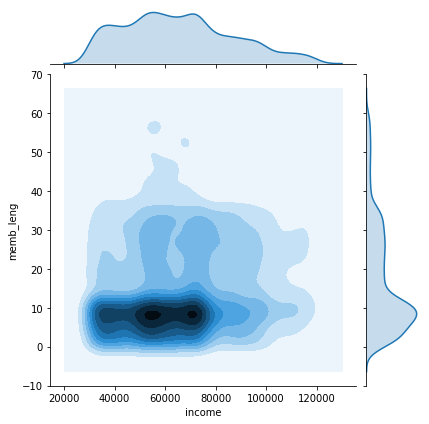

In [27]:
sns.jointplot(x=profile_new.dropna(subset=['income','age']).income,y=profile_new.dropna(subset=['income','age']).memb_leng,kind="kde")

It appears that the early and mid adopters tend to be distributed roughly the same as the general population.  

In [28]:
profile_new.dropna(subset=['income','age']).shape

(14825, 8)

In [29]:
profile_new.dropna(subset=['income','age'])[profile_new.dropna(subset=['income','age']).memb_leng<25].shape

(10812, 8)

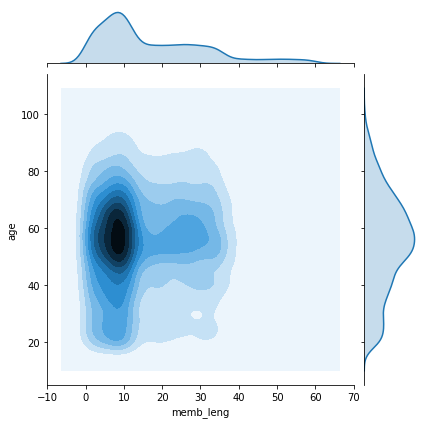

In [30]:
sns.jointplot(x='memb_leng',y='age',data=profile_new.dropna(subset=['income','age']),kind="kde")

<a id='sec_2_3'></a>
## Section 2.3: Explore Response Variable
<a href='#TOC'>Jump to top</a>

In [31]:
print(events_merged[['event_offer_received','event_offer_viewed','event_transaction','event_offer_completed']].sum())

tot_offers = events_merged.event_offer_received.sum()
tot_off_viewed = events_merged.event_offer_viewed.sum()
tot_off_purchased = events_merged.event_transaction.sum()
tot_off_rewarded = events_merged.event_offer_completed.sum()



tot_sum_purch = events_merged.trans_spend.sum()
#tot_sum_reward = events_merged.reward.sum()


print('Percentage viewed : {0:.2f}%'.format(100* tot_off_viewed/tot_offers))
print('Percentage offers purchased : {0:.2f}%'.format(100*tot_off_purchased/tot_offers))
print('Percentage offers viewed puchased : {0:.2f}%'.format(100*tot_off_purchased/tot_off_viewed))
print('Percentage of offers that were rewarded  : {0:.2f}%'.format(100*tot_off_rewarded/tot_off_purchased))
print('Percentage of purchases that were rewarded  : {0:.2f}%'.format(100*tot_off_rewarded/tot_off_purchased))

event_offer_received     76277
event_offer_viewed       56651
event_transaction        43067
event_offer_completed    33195
dtype: int64
Percentage viewed : 74.27%
Percentage offers purchased : 56.46%
Percentage offers viewed puchased : 76.02%
Percentage of offers that were rewarded  : 77.08%
Percentage of purchases that were rewarded  : 77.08%


In [32]:
#Standardize time events
events_merged['t_std'] = 0
events_merged['t_viewed_std'] = 0
events_merged['t_purc_std'] = 0 


In [34]:
events_merged.loc[:,'t_std'] = (events_merged.time)/events_merged.time.max()
events_merged.loc[:,'t_viewed_std'] = (events_merged.time_viewed - events_merged.time) / (events_merged.time_end - events_merged.time )
events_merged.loc[:,'t_purc_std'] = (events_merged.trans_time - events_merged.time) / (events_merged.time_end - events_merged.time )

First lets explore the main question in the simplist way possible?  Is there an overarching coorelation in purchasing to any demographic?

In [35]:
events_merged.columns

Index(['amount', 'duration', 'event', 'event_offer_completed',
       'event_offer_received', 'event_offer_viewed', 'event_transaction',
       'index', 'offer_id', 'person', 'reward', 'time', 'time_end',
       'time_viewed', 'trans_time', 'trans_spend', 'age', 'income', 'gender',
       'gender_F', 'gender_M', 'gender_O', 'memb_leng', 'difficulty', 'email',
       'mobile', 'social', 'web', 'offer_bogo', 'offer_discount',
       'offer_informational', 't_std', 't_viewed_std', 't_purc_std'],
      dtype='object')

In [36]:
events_merged_nona = events_merged.dropna(how='any',subset=['age','income','gender'])

In [37]:
events_merged_nona.columns

Index(['amount', 'duration', 'event', 'event_offer_completed',
       'event_offer_received', 'event_offer_viewed', 'event_transaction',
       'index', 'offer_id', 'person', 'reward', 'time', 'time_end',
       'time_viewed', 'trans_time', 'trans_spend', 'age', 'income', 'gender',
       'gender_F', 'gender_M', 'gender_O', 'memb_leng', 'difficulty', 'email',
       'mobile', 'social', 'web', 'offer_bogo', 'offer_discount',
       'offer_informational', 't_std', 't_viewed_std', 't_purc_std'],
      dtype='object')

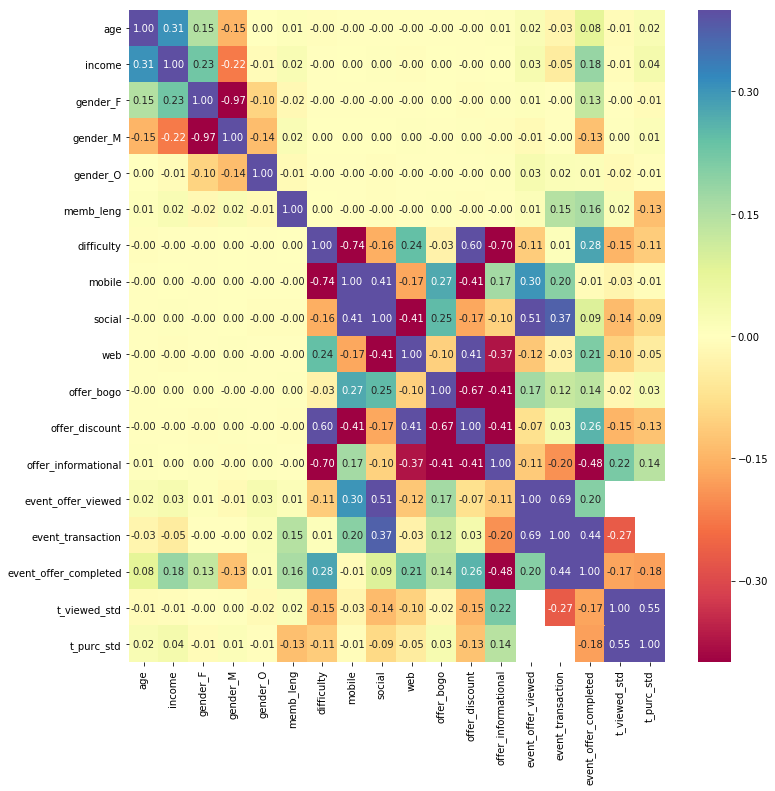

In [38]:
fig_hm, ax_hm = plt.subplots(figsize=(12,12))
sns.heatmap(events_merged_nona[['age', 'income', 'gender_F', 'gender_M', 'gender_O','memb_leng', 'difficulty', 'mobile', 'social', 'web',
       'offer_bogo', 'offer_discount', 'offer_informational',
       'event_offer_viewed', 'event_transaction', 'event_offer_completed','t_viewed_std',
       't_purc_std']].corr(),annot=True,ax=ax_hm,cmap='Spectral',vmin=-0.4, vmax=0.4,fmt='.2f')

There is a lot of information in this cooreation matrix.  I am focusing on which factors coorelate the most with event offer viewed, trans, and completion.
    - Viewed
        - Top Positive Coorelation
            - Offer on social media (0.5)
            - Offered on mobile platform (0.3)
        - Top Negative Coorelations
            - informational offer
            - difficulty
    - Transaction
        - Top Positive Coorelation
            - Offer on social media (0.37)
            - Offered on mobile platform (0.2)
        - Top Negative Coorelation
            - 
    

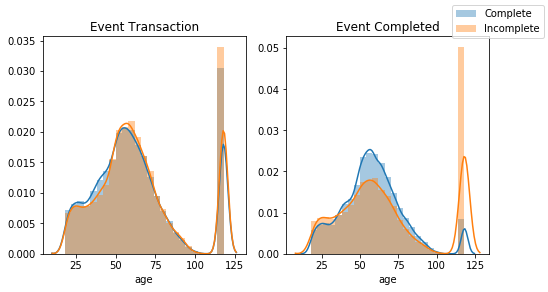

In [49]:

fig_age_response , ax_ar = plt.subplots(nrows=1, ncols=2,figsize=(8,4))
sns.distplot(events_merged[events_merged.event_transaction==1].age,bins=25,ax=ax_ar[0])
sns.distplot(events_merged[events_merged.event_transaction==0].age,bins=25,ax=ax_ar[0])
sns.distplot(events_merged[events_merged.event_offer_completed==1].age,bins=25,ax=ax_ar[1])
sns.distplot(events_merged[events_merged.event_offer_completed==0].age,bins=25,ax=ax_ar[1])
ax_ar[0].set_title('Event Transaction')
ax_ar[1].set_title('Event Completed')
fig_age_response.legend(labels=['Complete','Incomplete'])

The curves are almost identical, there does not seem to be an effect on age in making a transaciton

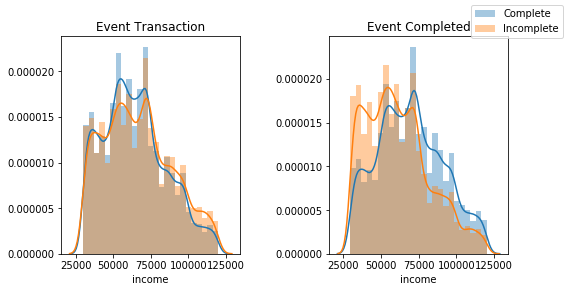

In [50]:
fig_income_response , ax_ir = plt.subplots(nrows=1, ncols=2,figsize=(8,4))
fig_income_response.subplots_adjust(hspace = .2,wspace = .5)
sns.distplot(events_merged[events_merged.event_transaction==1].income.dropna(),bins=25,ax=ax_ir[0])
sns.distplot(events_merged[events_merged.event_transaction==0].income.dropna(),bins=25,ax=ax_ir[0])
sns.distplot(events_merged[events_merged.event_offer_completed==1].income.dropna(),bins=25,ax=ax_ir[1])
sns.distplot(events_merged[events_merged.event_offer_completed==0].income.dropna(),bins=25,ax=ax_ir[1])
ax_ir[0].set_title('Event Transaction')
ax_ir[1].set_title('Event Completed')
fig_income_response.legend(labels=['Complete','Incomplete'])

Text(0.5,1,'Event Completed')

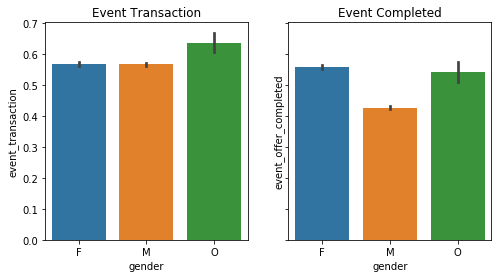

In [52]:
fig_gender_response, ax_gr = plt.subplots(nrows=1,ncols=2,figsize=(8,4),sharey=True)
sns.barplot(x=events_merged.gender,y=events_merged.event_transaction,ax=ax_gr[0])
sns.barplot(x=events_merged.gender,y=events_merged.event_offer_completed,ax=ax_gr[1])
ax_gr[0].set_title('Event Transaction')
ax_gr[1].set_title('Event Completed')

Men and Women appear to transact after viewing and offer at the same rate, but men disproportionally do not respond to the reward offers.  What is the baseline purchase frequency?

In [53]:
blah =pd.DataFrame(t_trans.groupby(by='person')['amount','event_transaction'].sum())



In [54]:
events_merged.columns

Index(['amount', 'duration', 'event', 'event_offer_completed',
       'event_offer_received', 'event_offer_viewed', 'event_transaction',
       'index', 'offer_id', 'person', 'reward', 'time', 'time_end',
       'time_viewed', 'trans_time', 'trans_spend', 'age', 'income', 'gender',
       'gender_F', 'gender_M', 'gender_O', 'memb_leng', 'difficulty', 'email',
       'mobile', 'social', 'web', 'offer_bogo', 'offer_discount',
       'offer_informational', 't_std', 't_viewed_std', 't_purc_std'],
      dtype='object')

What do we want to know about the study factors?
- Person
   - What is the distribution of offers
- Offer_Id (there are 10 offer ids)
  - How many offers were made of each ID?
  - How many offers were made to each person, on average?
- Difficulty
  - What was the representative range of difficulty?
- Distribution Method
  - 
- Offer Type
- Reward

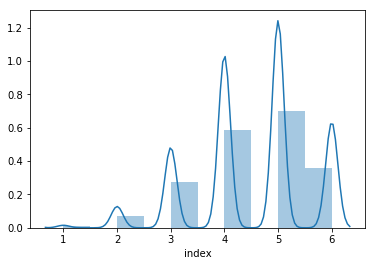

In [55]:
sns.distplot(events_merged.groupby(by='person').count()['index'],bins=10)

In [56]:
events_merged.groupby(by='offer_id').count()['index']

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    7668
2298d6c36e964ae4a3e7e9706d1fb8c2    7646
2906b810c7d4411798c6938adc9daaa5    7632
3f207df678b143eea3cee63160fa8bed    7617
4d5c57ea9a6940dd891ad53e9dbe8da0    7593
5a8bc65990b245e5a138643cd4eb9837    7618
9b98b8c7a33c4b65b9aebfe6a799e6d9    7677
ae264e3637204a6fb9bb56bc8210ddfd    7658
f19421c1d4aa40978ebb69ca19b0e20d    7571
fafdcd668e3743c1bb461111dcafc2a4    7597
Name: index, dtype: int64

In [57]:
events_merged.pivot_table(values='index',aggfunc='count',index='offer_id',columns=['person']).mean(axis=1)

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    1.203012
2298d6c36e964ae4a3e7e9706d1fb8c2    1.208854
2906b810c7d4411798c6938adc9daaa5    1.214320
3f207df678b143eea3cee63160fa8bed    1.203127
4d5c57ea9a6940dd891ad53e9dbe8da0    1.199526
5a8bc65990b245e5a138643cd4eb9837    1.205380
9b98b8c7a33c4b65b9aebfe6a799e6d9    1.208025
ae264e3637204a6fb9bb56bc8210ddfd    1.201443
f19421c1d4aa40978ebb69ca19b0e20d    1.209039
fafdcd668e3743c1bb461111dcafc2a4    1.199779
dtype: float64

In [58]:
fig,ax = 0,0

Text(0,0.955,'TIME PURCHASED (std) cumulative')

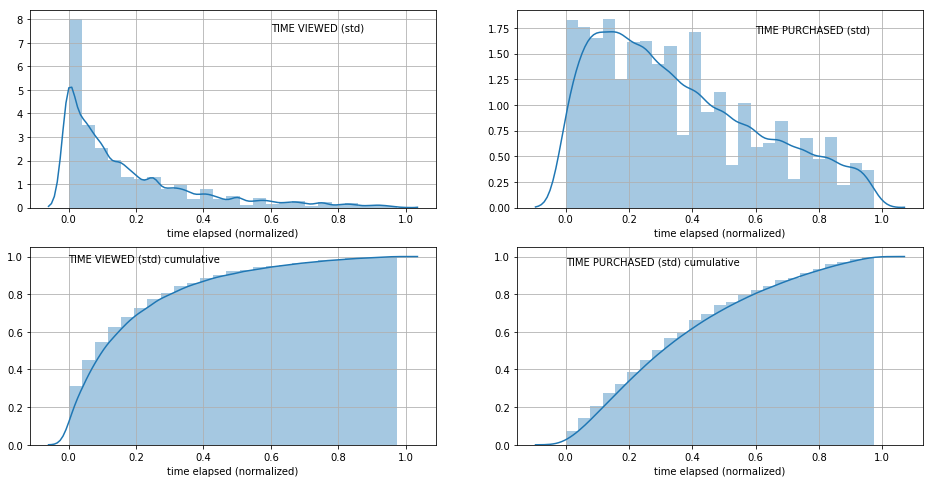

In [59]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(16,8))
fig.subplots_adjust(hspace = .2,wspace = .2)

sns.distplot(events_merged.t_viewed_std.dropna(),bins=25,ax=ax[0,0],norm_hist=True)
sns.distplot(events_merged.t_viewed_std.dropna(),hist_kws=dict(density=True,cumulative=True), kde_kws=dict(cumulative=True),bins=25,ax=ax[1,0])
sns.distplot(events_merged.t_purc_std.dropna(),bins=25,ax=ax[0,1],norm_hist=True)
sns.distplot(events_merged.t_purc_std.dropna(), hist_kws=dict(density=True,cumulative=True), kde_kws=dict(cumulative=True),ax=ax[1,1],bins=25)

for i,j in np.ndenumerate(ax):
    ax[i].grid(b=True)
    ax[i].set(xlabel='time elapsed (normalized)')

ax[0,0].annotate(s='TIME VIEWED (std)',xy = (0.6,7.5) )
ax[1,0].annotate(s='TIME VIEWED (std) cumulative',xy = (0,.975) )
ax[0,1].annotate(s='TIME PURCHASED (std)',xy = (0.6, 1.7) )
ax[1,1].annotate(s='TIME PURCHASED (std) cumulative',xy = (0,.955) )


Analysis:  The average view time is seemly early.  With 80% of people who will view it will view it witin the forst 30% of the time period.
The purchasing cumlative curve is flatter than the viewed cumulative curve and doesnt reach its inflection pount until about 70% of total respondeants reposnded at the 50% time point.

## Section 3.0:  Modeling
<a id='sec_3_0'></a>
<a href='#TOC'>Jump to top </a>

Ultimatly we would like to know, who is going to take the bait of 

### Section 3.1: Standardization and Normalization
<a id='sec_3_1'></a>
<a href='#TOC'>Jump to top</a>

In [60]:
events_merged.columns

Index(['amount', 'duration', 'event', 'event_offer_completed',
       'event_offer_received', 'event_offer_viewed', 'event_transaction',
       'index', 'offer_id', 'person', 'reward', 'time', 'time_end',
       'time_viewed', 'trans_time', 'trans_spend', 'age', 'income', 'gender',
       'gender_F', 'gender_M', 'gender_O', 'memb_leng', 'difficulty', 'email',
       'mobile', 'social', 'web', 'offer_bogo', 'offer_discount',
       'offer_informational', 't_std', 't_viewed_std', 't_purc_std'],
      dtype='object')

In [61]:
Xcol = ['t_std','duration','age', 'income', 'gender', 'gender_F', 'gender_M', 'gender_O',
       'memb_leng', 'difficulty', 'email', 'mobile', 'social', 'web',
       'offer_bogo', 'offer_discount', 'offer_informational']

Ycol = ['time_viewed','std_view_time',
       'std_trans_time','event_offer_viewed', 'event_transaction', 'event_offer_completed']

PLcol = ['time','index','person','offer_id','time_end','event_offer_received','trans_time', 'trans_spend']

In [63]:
# I will clean this up on future full run throughs

events_merged.drop(columns=['amount'],inplace=True)

events_merged.dropna(subset=['income','gender'],inplace=True)

events_merged.reward.fillna(value=0,inplace=True)

I am realizing that my standardization ignored the np.nan somehow, so i need to manage that